# Analysis of Traffic Data in Chicago from 2013-2020


# Introduction

## Authors: 
## Kevin Thompson, Dilruksha Jayaweera, Heber Nielsen, Sangrae Cho, Kumaraiah Pradeepkumar

Car accidents are no trivial matter in the United States. Roughly 800 car accidents occur every day in Illinois alone [@tribune]. Our project is to develop models to both predict and explain a subset of these entirely avoidable accidents in Chicago, Illinois. OpenWeather's historical weather database and the city government of Chicago's website to construct these models and insights. We also obtained the boundaries of the police beats from the city of Chicago's website. These datasets include factors that are widely believed to contribute to higher accident rates, such as weather, time, location, road conditions, and so forth.

  The primary goal of our exploration is to explore useful features for predicting the number of accidents in a given police shift in location clusters called "police beats". We hope that the results of our project could be used to further optimize the allocation of first responders across these beats. We believe that the effectiveness of a good prediction algorithm would be measured using one of the many of the many scoring rules described in [@czado]. As of this moment,we find the Dawid-Sebastiani and squared error scores to be the most appealing. 
  
  We now turn to the specifics of the data.
 
# Data
  
  

In [7]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns


# Define data types of attributes
dtypes = {'CRASH_DATE_EST_I': 'category', 'TRAFFIC_CONTROL_DEVICE': 'category', 'DEVICE_CONDITION': 'category',
         'WEATHER_CONDITION': 'category', 'LIGHTING_CONDITION': 'category', 'FIRST_CRASH_TYPE': 'category',
         'TRAFFICWAY_TYPE': 'category', 'ROADWAY_SURFACE_COND': 'category', 'ROAD_DEFECT': 'category',
         'REPORT_TYPE': 'category', 'CRASH_TYPE': 'category', 'INTERSECTION_RELATED_I': 'category',
         'NOT_RIGHT_OF_WAY_I': 'category', 'HIT_AND_RUN_I': 'category', 'DAMAGE': 'category', 
         'PRIM_CONTRIBUTORY_CAUSE': 'category', 'SEC_CONTRIBUTORY_CAUSE': 'category', 'STREET_DIRECTION': 'category',
         'STREET_NAME': 'category', 'PHOTOS_TAKEN_I': 'category', 'STATEMENTS_TAKEN_I': 'category',
         'DOORING_I': 'category', 'WORK_ZONE_I': 'category', 'WORK_ZONE_TYPE': 'category', 'WORKERS_PRESENT_I': 'category',
         'MOST_SEVERE_INJURY': 'category', 'BEAT_OF_OCCURRENCE': 'category'}

# Import the datasets
beats = gpd.read_file("data/policebeats.geojson")
weather = pd.read_csv("data/ChicagoWeather.csv", parse_dates = ['dt_iso'], usecols=['dt_iso', 'weather_main',
                                                                                           'weather_description'],
                     dtype={'weather_main':'category', 'weather_description':'category'})
crashes = pd.read_csv("data/TrafficCrashesChicago.csv", dtype=dtypes, parse_dates = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED'])

We found that the crash data prior to 2017 was infrequently captured, which leads us to not trust it. Therefore, we decided to remove data prior to 2017. This is not really a problem because the vast majority of the data comes after 2017. We will also merge the data sets, which requires us to resample our time series component in the process because the weather data was captured hourly. If we allow for periods of infrequent sampling to sneak in, then it will make us think (possibly incorrectly) that our target is not covariance stationary. 

In [ ]:
crashes.info()

There are several variables that have a significant number of missing values, though we don't find most of these particularly interesting for our use cases. Doorings, accident, worker zone variables, and so forth may be useful outcome variables but they are not so interesting for our current investigation. We will thus remove these variables, other variables that we felt would lead to target leakage, and variables we feel are downright unrelated to predicting number of accidents in a given beat during a given shift. The missingness by variable can be seen below. 

The features and outcomes we are interested in tend to have very few missing values. 

In [ ]:
# percent missingness by variable
pd.set_option('precision', 2)
crashes_missing = crashes.isna()
crashes_missing_sum = crashes_missing.sum()
crashes_missing_pct = (crashes_missing_sum / len(crashes))*100
crashes_missing_pct


In [4]:
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'],format="%Y-%m-%d %H:00:00 +0000 UTC")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63859 entries, 0 to 63858
Data columns (total 3 columns):
dt_iso                 63859 non-null datetime64[ns]
weather_main           63859 non-null category
weather_description    63859 non-null category
dtypes: category(2), datetime64[ns](1)
memory usage: 625.6 KB


In [12]:
import warnings
warnings.filterwarnings('ignore')

# Delete Data from before 2017
crashes = crashes[crashes.CRASH_DATE > '2017-01-01 00:00:00']
# Delete January 2020 Data because we don't have data for the entire month of January 
crashes_shortened = crashes[crashes.CRASH_DATE < '2020-01-01 00:00:00']


crashes_shortened = crashes_shortened.rename(columns={'RD_NO':'NUM_ACCIDENTS'})
# Aggregations for Groupby
aggregations = dict.fromkeys(['NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL',
                              'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
                              'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN'], np.sum)
aggregations.update({'HIT_AND_RUN_I': 'size', 'NUM_ACCIDENTS': 'size'})

aggs2 = {'NUM_ACCIDENTS': 'size'}

# Translate Crash Hours into Police Shifts
# Police Officer Shift Intervals. 1 starts at 6AM, 2 starts at 2PM, and 3 starts at 10PM.
shifts = dict.fromkeys([22, 23, 0, 1, 2, 3, 4, 5], 3)
shifts.update(dict.fromkeys([6, 7, 8, 9, 10, 11, 12, 13], 1))
shifts.update(dict.fromkeys([14, 15, 16, 17, 18, 19, 20, 21], 2))
crashes_shortened['SHIFT'] = crashes_shortened['CRASH_HOUR'].map(shifts).astype('category')

,BEAT_OF_OCCURRENCE,SHIFT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,...,RAIN_12H,RAIN_24H,RAIN_TODAY,SNOW_1H,SNOW_3H,SNOW_6H,SNOW_12H,SNOW_24H,SNOW_TODAY,CLOUDS_ALL
count,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.0,...,0.0,55199.000000,0.0,39593.000000,4925.000000,4009.000000,0.0,13513.000000,27.0,377839.000000
mean,1248.254410,1.745897,2.118768,0.170313,0.000903,0.018407,0.092529,0.058475,2.120684,0.0,...,NaN,5.940054,NaN,0.123556,0.502181,1.116827,NaN,3.831971,0.0,59.314078
std,709.531763,0.688047,0.658822,0.537572,0.032727,0.159605,0.391824,0.310588,1.311095,0.0,...,NaN,8.570660,NaN,0.304063,0.977629,1.988769,NaN,8.227568,0.0,35.149741
min,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,0.010000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.000000
25%,714.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,NaN,0.510000,NaN,0.000000,0.000000,0.000000,NaN,0.430000,0.0,20.000000
50%,1214.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,...,NaN,2.460000,NaN,0.000000,0.000000,0.380000,NaN,1.180000,0.0,75.000000
75%,1824.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,...,NaN,8.130000,NaN,0.200000,0.500000,1.150000,NaN,3.050000,0.0,90.000000
max,2535.000000,3.000000,18.000000,21.000000,3.000000,14.000000,21.000000,10.000000,61.000000,0.0,...,NaN,94.490000,NaN,8.400000,11.700000,12.150000,NaN,85.340000,0.0,100.000000


In [133]:
# Resample to hours to allow for merging between weather data and crashes data
crashes_beats_downsampled_grouped = crashes_shortened.groupby([pd.Grouper(key='CRASH_DATE', freq='H'),'BEAT_OF_OCCURRENCE', 'SHIFT'])                           

0         1562279580000000000
1         1564482120000000000
2         1565456400000000000
3         1565974380000000000
4         1566057840000000000
                 ...         
377625    1564930800000000000
377626    1566738420000000000
377627    1566712800000000000
377628    1565385840000000000
377629    1566321240000000000
Name: CRASH_DATE, Length: 319329, dtype: int64

In [ ]:
crashes_beats_agged = crashes_beats_downsampled_grouped.agg(aggregations)  

In [46]:
# Merge weather and crashes dataset
crashes_new = crashes_beats_agged.reset_index().merge(weather, how="left", left_on='CRASH_DATE', right_on='dt_iso')

In [ ]:
# Resample to days because we already have hours discretized to shifts
crashes_new_daily = crashes_new.groupby([pd.Grouper(key='CRASH_DATE', freq='D'), 'SHIFT', 'BEAT_OF_OCCURRENCE']).agg(aggs2).reset_index()

In [33]:
# Jupyter is bugged and causing memory leaks. My computer crashed a dozen times
# because it kept running out of its 16 GB of RAM, so pandas and Jupyter broke me and forced me replicate the code
# above in R. I know that this code works and it worked the other day, 
# but pandas and Jupyter just wants to take an eternity today for some reason. Not sure if something is wrong
# with my computer.
crash_per_hour = pd.read_csv("data/ChicagoCrashesPerHour.csv", parse_dates=['CRASH_DATE'], dtype = {'BEAT_OF_OCCURRENCE': 'category',
                                                                                                    'SHIFT': 'category'})
crash_per_hour.describe()


,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,HIT_AND_RUN_I,NUM_ACCIDENTS,...,RAIN_12H,RAIN_24H,RAIN_TODAY,SNOW_1H,SNOW_3H,SNOW_6H,SNOW_12H,SNOW_24H,SNOW_TODAY,CLOUDS_ALL
count,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.0,377839.000000,377839.000000,...,0.0,55199.000000,0.0,39593.000000,4925.000000,4009.000000,0.0,13513.000000,27.0,377839.000000
mean,2.118768,0.170313,0.000903,0.018407,0.092529,0.058475,2.120684,0.0,0.291844,1.053062,...,NaN,5.940054,NaN,0.123556,0.502181,1.116827,NaN,3.831971,0.0,59.314078
std,0.658822,0.537572,0.032727,0.159605,0.391824,0.310588,1.311095,0.0,0.464614,0.239590,...,NaN,8.570660,NaN,0.304063,0.977629,1.988769,NaN,8.227568,0.0,35.149741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,...,NaN,0.010000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,...,NaN,0.510000,NaN,0.000000,0.000000,0.000000,NaN,0.430000,0.0,20.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,1.000000,...,NaN,2.460000,NaN,0.000000,0.000000,0.380000,NaN,1.180000,0.0,75.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,1.000000,1.000000,...,NaN,8.130000,NaN,0.200000,0.500000,1.150000,NaN,3.050000,0.0,90.000000
max,18.000000,21.000000,3.000000,14.000000,21.000000,10.000000,61.000000,0.0,4.000000,7.000000,...,NaN,94.490000,NaN,8.400000,11.700000,12.150000,NaN,85.340000,0.0,100.000000


The attributes in this resulting dataframe set can be divided into injury variables, weather variables, time variables, and the number of accidents in a given hour at a given beat. CRASH_DATE gives a datetime for the crash, all of the injury variables yield the number of people who are injured in that specific manner as a result of the accidents, HIT_AND_RUN_I tells us the number of hit and runs during that hour in that beat, and CRASH_HOUR is an integer variable from 0 to 24, with 0 = midnight. NUM_ACCIDENTS, in its current form gives us the number of accidents in an hour in a specific beat. dt_iso is the datetime of a weather incident in the ISO format. weather_main and weather_description describe the state of the weather at that specific time. For example, they might say "light snow" or "heavy rain". There is significant intuitive justification for believing that these variables significantly contribute to accident rates. 

# Summary

In [18]:
crash_per_hour.describe()

,BEAT_OF_OCCURRENCE,SHIFT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,...,RAIN_12H,RAIN_24H,RAIN_TODAY,SNOW_1H,SNOW_3H,SNOW_6H,SNOW_12H,SNOW_24H,SNOW_TODAY,CLOUDS_ALL
count,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.000000,377839.0,...,0.0,55199.000000,0.0,39593.000000,4925.000000,4009.000000,0.0,13513.000000,27.0,377839.000000
mean,1248.254410,1.745897,2.118768,0.170313,0.000903,0.018407,0.092529,0.058475,2.120684,0.0,...,NaN,5.940054,NaN,0.123556,0.502181,1.116827,NaN,3.831971,0.0,59.314078
std,709.531763,0.688047,0.658822,0.537572,0.032727,0.159605,0.391824,0.310588,1.311095,0.0,...,NaN,8.570660,NaN,0.304063,0.977629,1.988769,NaN,8.227568,0.0,35.149741
min,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,0.010000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.000000
25%,714.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,NaN,0.510000,NaN,0.000000,0.000000,0.000000,NaN,0.430000,0.0,20.000000
50%,1214.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,...,NaN,2.460000,NaN,0.000000,0.000000,0.380000,NaN,1.180000,0.0,75.000000
75%,1824.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,...,NaN,8.130000,NaN,0.200000,0.500000,1.150000,NaN,3.050000,0.0,90.000000
max,2535.000000,3.000000,18.000000,21.000000,3.000000,14.000000,21.000000,10.000000,61.000000,0.0,...,NaN,94.490000,NaN,8.400000,11.700000,12.150000,NaN,85.340000,0.0,100.000000


Above we see summary statistics for the numeric variables in our dataset. There are somew extreme outliers in our dataset, but we could not find any evidence to indicate that they are mistakes. Furthermore, is entirely plausible that there could be accidents that involve 209 people in a city as dense and populous as Chicago. It is furthermore clear that all of our variables have a significant right skew, which is further confirmation to us that the outliers merely reflect the underlying nature of the data generating process.

In [49]:
categorical_vars = crashes_new.select_dtypes(include=['category'])
categorical_vars['weather_description'].value_counts()

overcast clouds                    67225
broken clouds                      49017
few clouds                         42345
sky is clear                       41884
scattered clouds                   40438
light rain                         35667
mist                               17659
moderate rain                       8477
light snow                          7792
light intensity drizzle             2288
heavy intensity rain                1336
fog                                  612
snow                                 503
haze                                 450
thunderstorm with light rain         393
thunderstorm with rain               296
thunderstorm                         249
thunderstorm with heavy rain         180
proximity thunderstorm               147
light rain and snow                   58
smoke                                 41
very heavy rain                       18
drizzle                               18
heavy snow                            13
thunderstorm wit

In [50]:
categorical_vars['weather_main'].value_counts()

Clouds          199025
Rain             45498
Clear            41884
Mist             17659
Snow              8366
Drizzle           2306
Thunderstorm      1272
Fog                612
Haze               450
Smoke               41
Dust                 0
Tornado              0
Name: weather_main, dtype: int64

Both of these variables follow standard intuition. The weather tends to be cloudy or clear with a significant number of snowy days due to Chicago's location and proximity to a large body of water.

# Important Attributes

At first glance, we believe that the injury and number of units variables are the most important. 

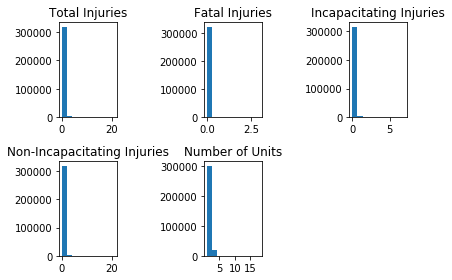

In [39]:
plt.subplot(2,3,1)
plt.hist(crashes.INJURIES_TOTAL)
plt.title('Total Injuries')
plt.subplot(2,3,2)
plt.hist(crashes.INJURIES_FATAL)
plt.title("Fatal Injuries")
plt.subplot(2,3,3)
plt.hist(crashes.INJURIES_INCAPACITATING)
plt.title("Incapacitating Injuries")
plt.subplot(2,3,4)
plt.hist(crashes.INJURIES_NON_INCAPACITATING)
plt.title("Non-Incapacitating Injuries")
plt.subplot(2,3,5)
plt.hist(crashes.NUM_UNITS)
plt.title("Number of Units")

plt.tight_layout()

Histograms are great for count data, so we felt that this was the best way to visualizes injuries and number of units. Given the low counts, these poisson-esque distributions are to be expected; however, they may yet become more informative when we do some feature engineering and look at them from the perspective of rates. The number of units (people, automobiles, etc.) tends to hover around 1-4, which makes a great deal of sense. Given that fact, it makes sense that many of the injury variables tend to hover around 1-2.

# Interesting Relationships

We will group these variables by beat later on when we are interested in clustering our observations. For now, our data has time-varying components, space-varying components, and components that vary over both. There are several theoretical reasons to suppose that accident rates vary across time as well as location, so we have to first see if there is a stable time structure for our target variable. This will best be seen if we marginalize across the days and the beats.

In [56]:
# Marginalize across days of the month to filter out noise for plotting

aggregations = dict.fromkeys(['NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
                        'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
                        'INJURIES_UNKNOWN', 'NUM_ACCIDENTS'], np.sum)
aggregations.update(dict.fromkeys(['weather_main', 'weather_description', 'HIT_AND_RUN_I'], 'size'))
crashes_over_time = crashes_new_daily.groupby(pd.Grouper(key='CRASH_DATE', freq='M')).agg(aggs2)


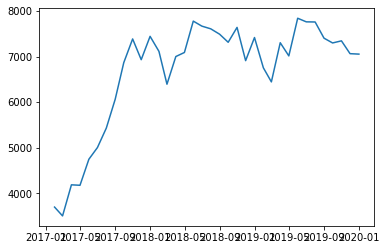

In [57]:
# plot time series of monthly crashes
plt.plot(crashes_over_time.index, crashes_over_time.NUM_ACCIDENTS)

In this plot we can see that the time series plot is not covariance stationary across the time-horizon. There was a sudden structural break in the mean number of accidents per month starting in mid 2017. We currently do not have an explanation for this, but we believe that following up on this peculiarity will lead to better model performance in the future. It could be the case that this reflects even better data collection methods being adopted during 2017. If so, we could consider dropping 2017 as well to get a better view of the series's stationarity. 

Next we will see how accidents vary across beats.

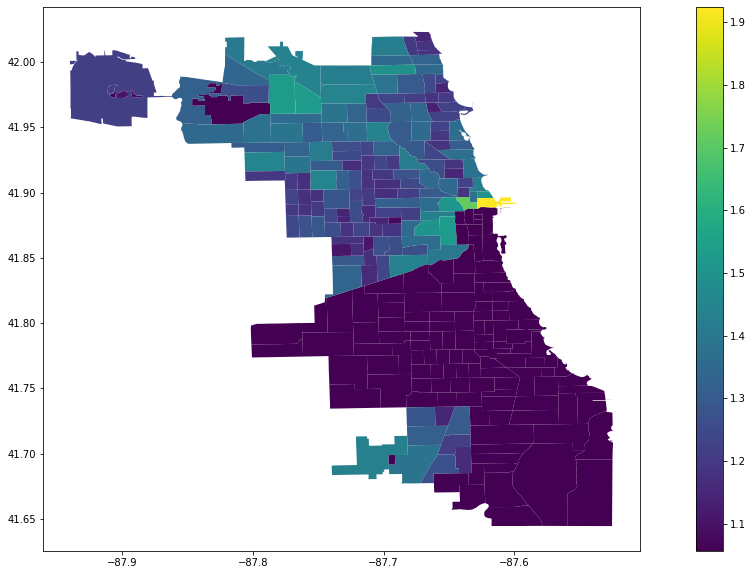

In [101]:
top_beats = crashes_new_daily.groupby('BEAT_OF_OCCURRENCE').agg({'NUM_ACCIDENTS':np.mean}).sort_values('NUM_ACCIDENTS',
                                                                                                      ascending=False)
#merge beats data
beats_combined = beats.merge(top_beats, how='left', left_on='beat_num', right_on='BEAT_OF_OCCURRENCE')
beats_combined.plot(column='NUM_ACCIDENTS', legend=True, figsize=(20,10))

Interestingly, we can see a very clear pattern here. South Chicago is safer to drive in, Northern Chicago is moderately risky to drive in, and there are a couple points in mid-eastern chicago that are far and above more dangerous than any other part of the city. This plot will probably be among the most helpful when it comes to model-building because we can see this clear spatial pattern that allows us cluster beats themselves. 

Now let's see how crashes behave across shifts.

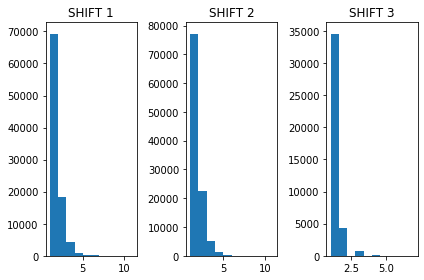

In [126]:
plt.figsize = (20,60)
plt.subplot(1,3,1)
plt.hist(crashes_new_daily.loc[crashes_new_daily.SHIFT==1].NUM_ACCIDENTS)
plt.title('SHIFT 1')
plt.subplot(1,3,2)
plt.hist(crashes_new_daily.loc[crashes_new_daily.SHIFT==2].NUM_ACCIDENTS)
plt.title('SHIFT 2')
plt.subplot(1,3,3)
plt.hist(crashes_new_daily.loc[crashes_new_daily.SHIFT==3].NUM_ACCIDENTS)
plt.title('SHIFT 3')
plt.tight_layout()


In [128]:
crashes_new_daily.groupby('SHIFT').agg({'NUM_ACCIDENTS': np.mean})

,NUM_ACCIDENTS
SHIFT,
1,1.343989
2,1.362946
3,1.157928


Conditional on shift, the number of accidents appears to have a very clear poisson distribution. This is in accordance with expectation. The sheer niceness of this distributional form is convenient for modelling and the differences in mean number of accidents per shift is in accordance with intuition. It is far safer to drive at night and the riskiest time to be driving is when everyone is coming home from work. 

In [25]:
pd.crosstab(crash_per_hour.WEATHER_MAIN, crash_per_hour.WEATHER_DESCRIPTION)

WEATHER_DESCRIPTION,broken clouds,drizzle,few clouds,fog,haze,heavy intensity rain,heavy snow,light intensity drizzle,light rain,light rain and snow,...,scattered clouds,sky is clear,smoke,snow,thunderstorm,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain
WEATHER_MAIN,,,,,,,,,,,,,,,,,,,,,
Clear,0,0,0,0,0,0,0,0,0,0,...,0,46351,0,0,0,0,0,0,0,0
Clouds,61133,0,51884,0,0,0,0,0,0,0,...,48210,0,0,0,0,0,0,0,0,0
Drizzle,0,21,0,0,0,0,0,3027,0,0,...,0,0,0,0,0,0,0,0,0,0
Fog,0,0,0,877,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Haze,0,0,0,0,557,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rain,0,0,0,0,0,1499,0,0,40697,0,...,0,0,0,0,0,0,0,0,0,28
Smoke,0,0,0,0,0,0,0,0,0,0,...,0,0,41,0,0,0,0,0,0,0
Snow,0,0,0,0,0,0,23,0,0,75,...,0,0,0,546,0,0,0,0,0,0


Here we see that light weather is far more common than heavy weather for all types of main_weather. This is interesting because it may be the case that because weather tends to mostly be light, the WEATHER_MAIN column may not explain as much as the WEATHER_DESCRIPTION column. After all, it's not that hard to drive in light weather. Adding more factors slows down algorithms, but it may be worth it here.

Next we will examine injuries to see if we can find some interesting relationships there.

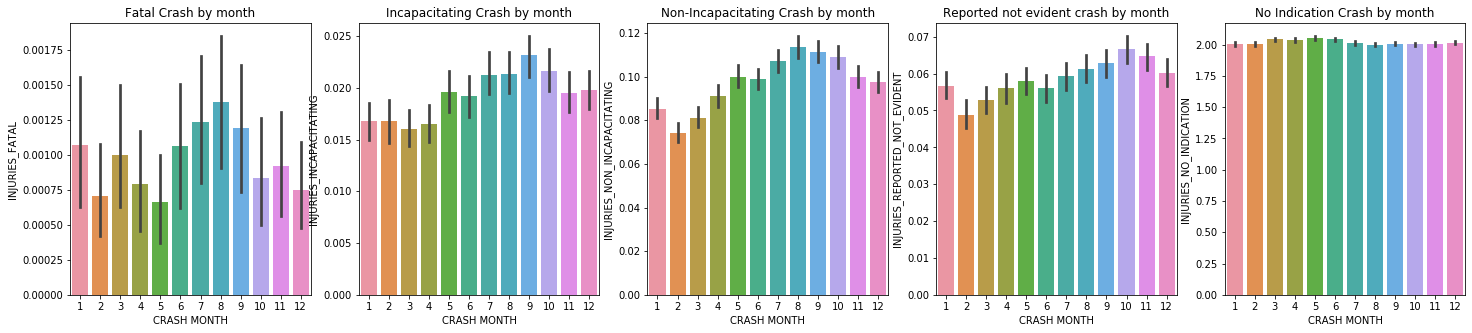

<Figure size 432x288 with 0 Axes>

In [30]:
fig, ax = plt.subplots(1, 5, figsize = (25, 5));

sns.barplot(x="CRASH_MONTH",y="INJURIES_FATAL",  data=crashes, ax=ax[0]);
sns.barplot(x="CRASH_MONTH", y="INJURIES_INCAPACITATING",  data=crashes, ax=ax[1]);
sns.barplot(x="CRASH_MONTH", y="INJURIES_NON_INCAPACITATING",  data=crashes, ax=ax[2]);
sns.barplot(x="CRASH_MONTH", y="INJURIES_REPORTED_NOT_EVIDENT",  data=crashes, ax=ax[3]);
sns.barplot(x="CRASH_MONTH", y="INJURIES_NO_INDICATION",  data=crashes, ax=ax[4]);
[ax[i].set_xlabel('CRASH MONTH') for i in range(5)]
ax[0].set_title('Fatal Crash by month')
ax[1].set_title('Incapacitating Crash by month')
ax[2].set_title('Non-Incapacitating Crash by month')
ax[3].set_title('Reported not evident crash by month')
ax[4].set_title('No Indication Crash by month')

plt.show()
plt.tight_layout()

The degree of seasonality in fatalities is the most immediate thing you'll notice from these charts. The summer months are the most dangerous months of the year to be driving. This is counter to expectation, where we expected the winter months to be the most dangerous. After some reflection, a possible explanation would be that people are more careful when they are driving in the snow and are thus less likely to engage in behavior that endangers their life. They may also want to drive less because driving in the snow can be a hassle. 

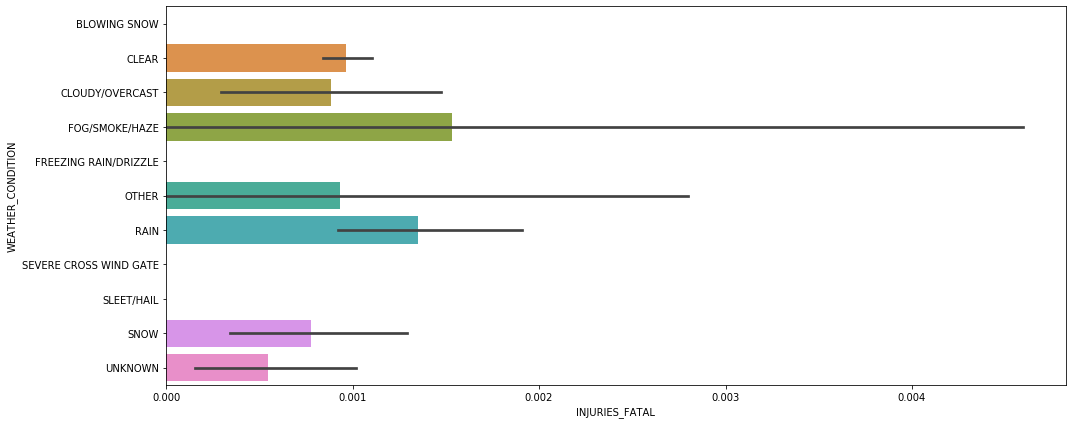

In [31]:
plt.figure(figsize=(15,6))
sns.barplot(y="WEATHER_CONDITION", x="INJURIES_FATAL",  data=crashes);
plt.tight_layout()



It makes intuitive sense that fog/smoke/haze would be riskier than clear weather and the data agrees with this intuition. What is interesting here is that snow is less risky than clear weather, yet rainy weather is more risky than clear weather. A possible explanation is that people overestimate the risks of driving in the snow and underestimate the risks of driving in the rain.

# Possible Feature Engineering

We believe that features that could be created from the data in the future include different rates of injury per number of units involved in a car accident. Danger is really about what it does to the people involved and it may be the case that something that is observed to be riskier is merely so because more people just so happened to be involved in the accidents at those times.